## 참조 사이트: https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html

In [30]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:11<00:00, 2270069.22it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 194347.49it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 653090.22it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5055555.37it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
from torchvision import transforms

mean = (0.2860,)
std = (0.3530,)

# MNIST 이미지를 정규화(Normalize): 0~255 uint8 -> 0~1사이의 float
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     #평균, 표준편차
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize(mean, std)
])

In [33]:
train_ratio = 0.8

train_size = int(len(training_data) * train_ratio)
valid_size = int(len(training_data) - train_size)

print(train_size, valid_size)

48000 12000


In [34]:
#random_split으로 데이터 나누기
from torch.utils.data import random_split

train_dataset, valid_dataset = random_split(training_data, [train_size, valid_size])

In [35]:
from torch.utils.data import DataLoader

batch_size = 64

#데이터 로더에 넣기
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [36]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [38]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

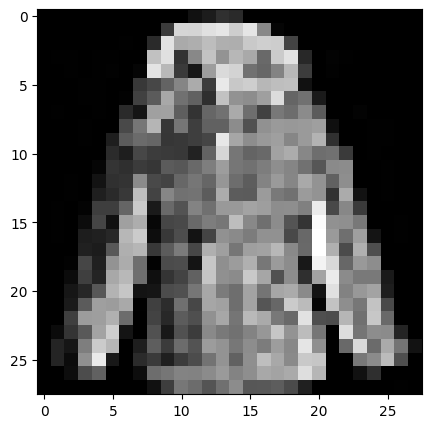

4 Coat


In [46]:
#이미지를 시각화, batch size=64라서 0~63번 인덱스 중에 한 장을 선택해서 시각화
import random

idx = random.randint(0,63)
plt.figure(figsize=(5,5))
plt.imshow(images[idx].squeeze(), cmap='gray')
plt.show()
# print(labels[idx].item())
print(labels[idx].item(), labels_map[labels[idx].item()])

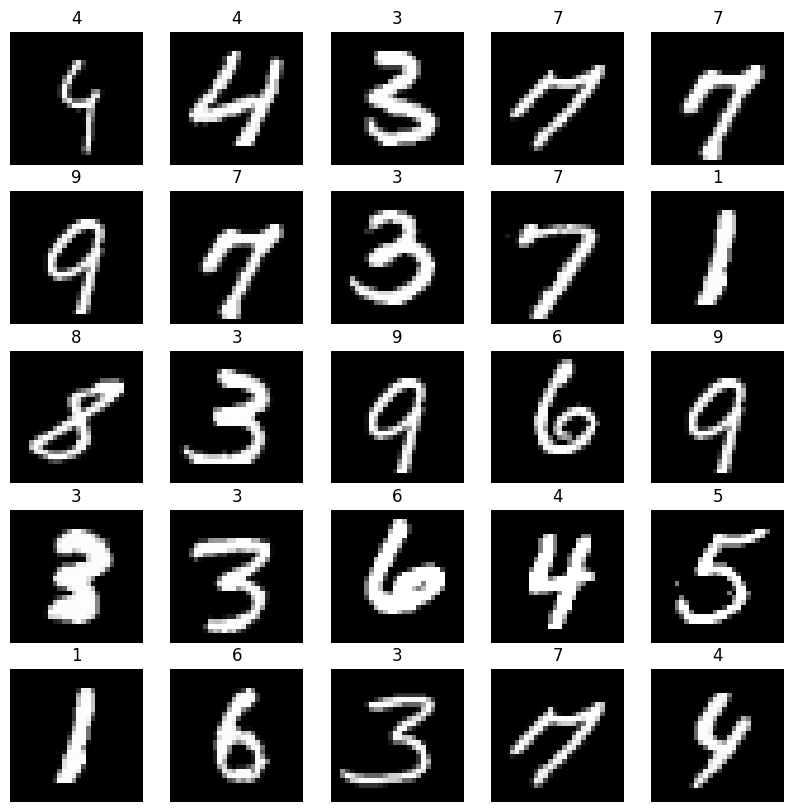

In [9]:
#nxn으로 이미치를 출력
n = 5

fig = plt.figure(figsize=(10,10))
for i in range(n*n):
    idx = random.randint(0,63)
    plt.subplot(n,n,i+1)
    plt.imshow(images[idx].squeeze(), cmap='gray')
    plt.title(labels[idx].item())
    plt.axis('off')
plt.show()

In [10]:
from collections import Counter

labels = training_data.targets  # train_dataset.targets에 라벨 정보가 저장됨


# 고유한 클래스와 갯수 확인
class_count = Counter(labels.numpy())
num_classes = len(class_count)

print(f"MNIST 데이터셋의 클래스 수: {num_classes}")
print(f"각 클래스별 이미지 개수: {class_count}")

MNIST 데이터셋의 클래스 수: 10
각 클래스별 이미지 개수: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [11]:
from torch import nn
from torch.nn import functional as F
# 신경망 모델 정의

input_node = 28*28
hidden_node1 = 512
hidden_node2 = 256
output_node = 10 # 0~9

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # 입력 레이어 -> 첫 번째 중간 레이어
        self.fc2 = nn.Linear(512, 256)      # 첫 번째 중간 레이어 -> 두 번째 중간 레이어
        self.fc3 = nn.Linear(256, 10)       # 두 번째 중간 레이어 -> 출력 레이어 (10개 클래스)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 입력 이미지를 일렬로 펴서 28*28=784 크기의 벡터로 변환
        x = F.relu(self.fc1(x))  # 첫 번째 중간 레이어에서 ReLU 활성화 함수 적용
        x = F.relu(self.fc2(x))  # 두 번째 중간 레이어에서 ReLU 활성화 함수 적용
        x = self.fc3(x)          # 출력 레이어
        return x

In [23]:
lr = 0.001

model = Net().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [24]:
train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

In [25]:
def train(dataloader, model, loss_fn, optimizer):
    train_correct = 0
    train_total = 0

    #신경망의 모드를 훈련 모드로 설정
    model.train()

    #매 batch마다 loss를 누적
    train_loss = 0.0

    #batch 사이즈만큼 이미지와 레이블을 가져와서 gpu로 보내기
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        #기울기를 0으로 초기화
        optimizer.zero_grad()

        #이미지로 추론해서 예측값 출력
        y_pred = model(images)

        #손실값 계산
        loss = loss_fn(y_pred, labels)

        #오차역전파법으로 경사하강법, 기울기 구하기
        loss.backward()
        #실제 W,b 값 업데이트하기
        optimizer.step()

        _, predicted = torch.max(y_pred.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        #loss 값 누적하기
        train_loss += loss.item()

    train_loss_list.append(train_loss)
    train_acc = (train_correct/train_total)*100
    train_acc_list.append(train_acc)

    return train_loss

In [26]:
def valid(dataloader, model, loss_fn):
    #신경망의 모드를 평가 모드로 설정
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    #기울기를 구하지 않는다.
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            #이미지로 추론해서 예측값 출력
            y_pred = model(images)

            #손실값 계산
            loss = loss_fn(y_pred, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss_list.append(valid_loss)
    valid_acc = (correct/total)*100
    valid_acc_list.append(valid_acc)

    accuracy = 100 * correct / total
    return valid_loss, accuracy

In [27]:
epochs = 20

for epoch in range(epochs):
    #매 epoch마다 파라미터(가중치) 학습
    train_loss = train(train_loader, model, loss_fn, optimizer)

    #매 epoch마다 loss 값을 출력
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}")

    valid_loss, val_acc = valid(valid_loader, model, loss_fn)
    print(f"Validation Loss: {valid_loss/len(valid_loader):.4f}, Validation Accuracy: {val_acc:.2f}%")

Epoch 1/20, Train Loss: 0.2374
Validation Loss: 0.0890, Validation Accuracy: 97.42%
Epoch 2/20, Train Loss: 0.0887
Validation Loss: 0.0672, Validation Accuracy: 97.69%
Epoch 3/20, Train Loss: 0.0598
Validation Loss: 0.0459, Validation Accuracy: 98.35%
Epoch 4/20, Train Loss: 0.0413
Validation Loss: 0.0218, Validation Accuracy: 99.24%
Epoch 5/20, Train Loss: 0.0309
Validation Loss: 0.0332, Validation Accuracy: 98.89%
Epoch 6/20, Train Loss: 0.0276
Validation Loss: 0.0157, Validation Accuracy: 99.44%
Epoch 7/20, Train Loss: 0.0214
Validation Loss: 0.0142, Validation Accuracy: 99.54%
Epoch 8/20, Train Loss: 0.0189
Validation Loss: 0.0135, Validation Accuracy: 99.44%
Epoch 9/20, Train Loss: 0.0155
Validation Loss: 0.0124, Validation Accuracy: 99.56%
Epoch 10/20, Train Loss: 0.0167
Validation Loss: 0.0158, Validation Accuracy: 99.50%
Epoch 11/20, Train Loss: 0.0130
Validation Loss: 0.0083, Validation Accuracy: 99.72%
Epoch 12/20, Train Loss: 0.0123
Validation Loss: 0.0062, Validation Accura

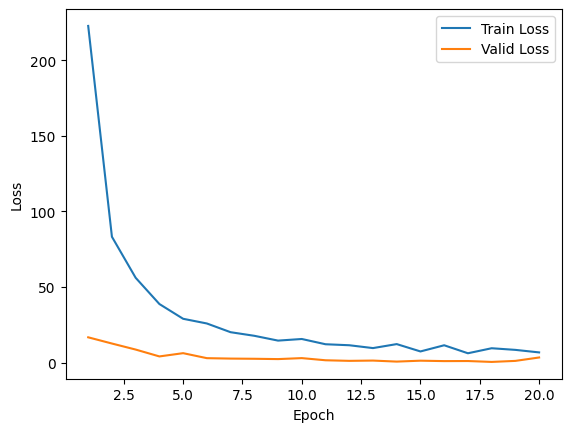

In [28]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1,epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1,epochs+1), valid_loss_list, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

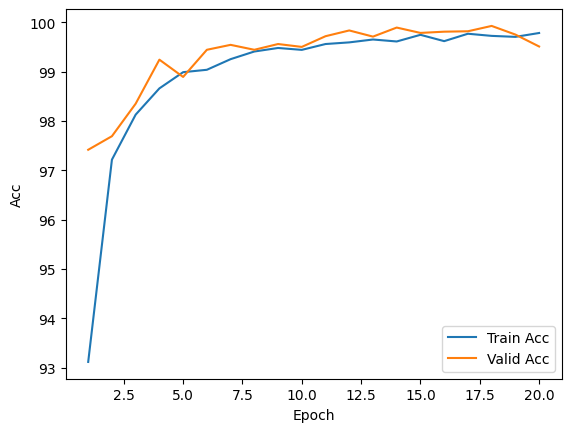

In [29]:
plt.figure()
plt.plot(range(1,epochs+1), train_acc_list, label='Train Acc')
plt.plot(range(1,epochs+1), valid_acc_list, label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()